In [1]:
# Importing useful libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams

from statsmodels.tsa.seasonal import seasonal_decompose as SDecompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
import itertools
from math import sqrt
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Time_series_analysis_and_forecast_DATASET.csv')
df.head()

,FullDate,Tmax,SysLoad,GasPrice,ElecPrice
0,2010-09-01 00:00:00,15.8,1688.215,3.69,23.710
1,2010-09-01 01:00:00,15.8,1669.195,3.69,22.635
2,2010-09-01 02:00:00,15.8,1491.980,3.69,22.565
3,2010-09-01 03:00:00,15.8,1330.760,3.69,18.910
4,2010-09-01 04:00:00,15.8,1247.940,3.69,18.030


In [3]:
df.shape

(92016, 5)

In [4]:
df.describe()

,Tmax,SysLoad,GasPrice,ElecPrice
count,92016.000000,92016.000000,92016.000000,92016.000000
mean,231.696688,797.623357,6.016163,65.798356
std,4562.128748,613.520156,2.608116,213.144084
min,9.900000,-1596.810100,0.000000,-924.820000
25%,17.300000,417.119800,3.936900,31.543750
50%,21.900000,856.467925,5.165600,48.715000
75%,27.600000,1221.293675,8.023300,76.495000
max,99999.900000,3264.166300,29.990000,14700.000000


In [5]:
df.isnull().values.any()

False

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92016 entries, 0 to 92015
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   FullDate   92016 non-null  object 
 1   Tmax       92016 non-null  float64
 2   SysLoad    92016 non-null  float64
 3   GasPrice   92016 non-null  float64
 4   ElecPrice  92016 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.5+ MB


In [7]:
#  convert column to datetime
df['FullDate'] = pd.to_datetime(df['FullDate'])
df.set_index('FullDate', inplace=True)

In [8]:
df.head()

,Tmax,SysLoad,GasPrice,ElecPrice
FullDate,,,,
2010-09-01 00:00:00,15.8,1688.215,3.69,23.710
2010-09-01 01:00:00,15.8,1669.195,3.69,22.635
2010-09-01 02:00:00,15.8,1491.980,3.69,22.565
2010-09-01 03:00:00,15.8,1330.760,3.69,18.910
2010-09-01 04:00:00,15.8,1247.940,3.69,18.030


In [9]:
# Resampling "Daily"
df_daily = df.resample('D').sum()

In [10]:
df_daily.head()

,Tmax,SysLoad,GasPrice,ElecPrice
FullDate,,,,
2010-09-01,379.2,41565.380,88.56,2751.700
2010-09-02,369.6,38898.990,88.56,570.810
2010-09-03,439.2,41665.760,106.80,504.975
2010-09-04,328.8,35638.085,81.36,502.275
2010-09-05,357.6,35611.410,106.80,500.555


In [11]:
df_daily.reset_index(inplace=True)

## Question 11

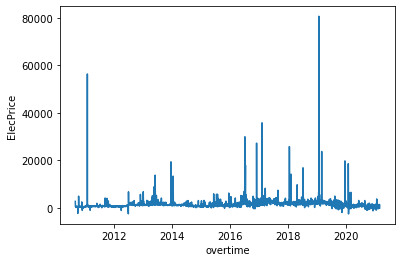

In [12]:
# Plotting
plt.plot(df_daily.FullDate,df_daily.ElecPrice)
plt.xlabel( 'overtime' ) 
plt.ylabel( 'ElecPrice' ) 
plt.show()

## Question 12

In [13]:
from statsmodels.tsa.stattools import adfuller 
adf_result1 = adfuller(df_daily[ 'SysLoad' ])
adf_result2 = adfuller(df_daily[ 'GasPrice' ]) 
print(f'p-value for SysLoad: {adf_result1[ 1 ]:.6f}') 
print(f'p-value for GasPrice: {adf_result2[ 1 ]:.6f}') 

p-value for SysLoad: 0.004254
p-value for GasPrice: 0.045027


## Question 13

In [14]:
from statsmodels.tsa.stattools import adfuller 
adf_result3 = adfuller(df_daily[ 'GasPrice' ]) 
adf_result4 = adfuller(df_daily['ElecPrice'])
print( 'Critical Values for GasPrice:' ) 
for k, v in adf_result3[ 4 ].items(): 
 print( f' {k} : {v:.4f} ' )
print( 'Critical Values for ElecPrice:' ) 
for k, v in adf_result4[ 4 ].items(): 
 print( f' {k} : {v:.4f} ' ) 



Critical Values for GasPrice:
 1% : -3.4321 
 5% : -2.8623 
 10% : -2.5672 
Critical Values for ElecPrice:
 1% : -3.4321 
 5% : -2.8623 
 10% : -2.5672 


In [15]:
# Preparing the data for univariate analysis
df_uni = df_daily[['FullDate','ElecPrice']]

# making a new dataframe from df_uni by renaming the columns
new_df = df_uni.rename(columns={"FullDate": "ds", "ElecPrice": "y"})
new_df.head()

,ds,y
0,2010-09-01,2751.700
1,2010-09-02,570.810
2,2010-09-03,504.975
3,2010-09-04,502.275
4,2010-09-05,500.555


In [16]:
# Splitting the dataset into train and test sets respectively according to the quiz instructions
x_test = new_df[2757:]
x_train = new_df[:2757]

In [17]:
x_test.shape, x_train.shape

((1077, 2), (2757, 2))

In [18]:
# building the model
from fbprophet import Prophet
model = Prophet(daily_seasonality=True)
model.fit(x_train)

In [19]:
# Predicting the values of the test set 
forecast = model.predict(x_test)

In [20]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-03-20,4199.026666,251.743232,4766.142816,4199.026666,4199.026666,-1675.427379,-1675.427379,-1675.427379,-1519.821457,...,9.731678,9.731678,9.731678,-165.337600,-165.337600,-165.337600,0.0,0.0,0.0,2523.599287
1,2018-03-21,4199.802407,210.598967,4936.466782,4199.802407,4199.802407,-1522.931388,-1522.931388,-1522.931388,-1519.821457,...,159.356593,159.356593,159.356593,-162.466525,-162.466525,-162.466525,0.0,0.0,0.0,2676.871018
2,2018-03-22,4200.578147,378.587552,5163.078995,4200.578147,4200.578147,-1424.738648,-1424.738648,-1424.738648,-1519.821457,...,257.114912,257.114912,257.114912,-162.032102,-162.032102,-162.032102,0.0,0.0,0.0,2775.839500
3,2018-03-23,4201.353888,51.327123,4794.410693,4201.353888,4201.353888,-1633.414317,-1633.414317,-1633.414317,-1519.821457,...,50.275296,50.275296,50.275296,-163.868157,-163.868157,-163.868157,0.0,0.0,0.0,2567.939571
4,2018-03-24,4202.129629,-221.672330,4543.299417,4202.129629,4202.129629,-1959.002590,-1959.002590,-1959.002590,-1519.821457,...,-271.449061,-271.449061,-271.449061,-167.732072,-167.732072,-167.732072,0.0,0.0,0.0,2243.127039


In [21]:
forecast.shape

(1077, 22)

## Question 14

In [22]:
# Computing the MAPE
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

actual = x_test['y']
pred = forecast['yhat']

mape(actual, pred)

540.7988757296991

## Question 15

In [23]:
# Computing the RMSE by comparing the real values and the forecasted values
mse_prophet = mean_squared_error(x_test.y,forecast.yhat)
print ("RMSE FOR PROPHET {:.2f}".format(sqrt(mse_prophet)))


RMSE FOR PROPHET 3200.29


## Question 16

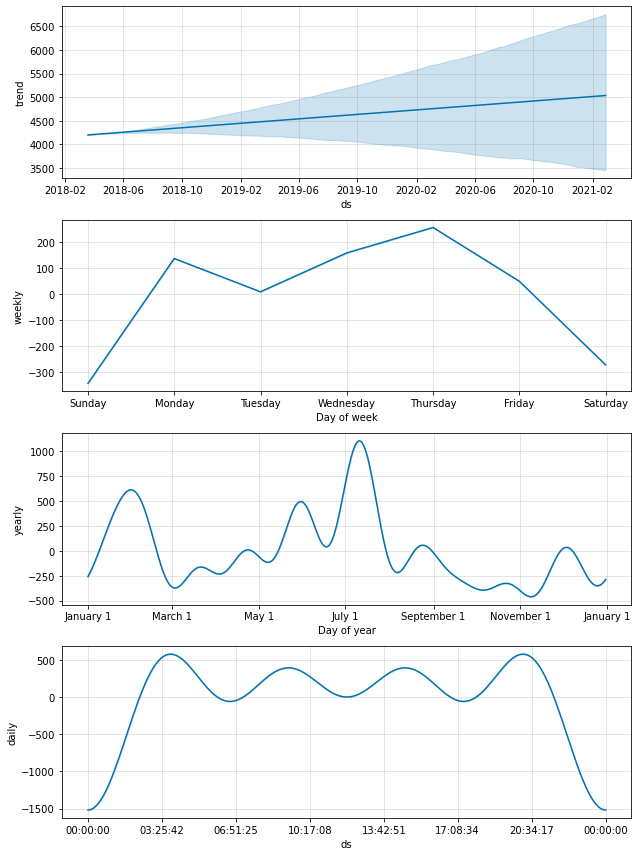

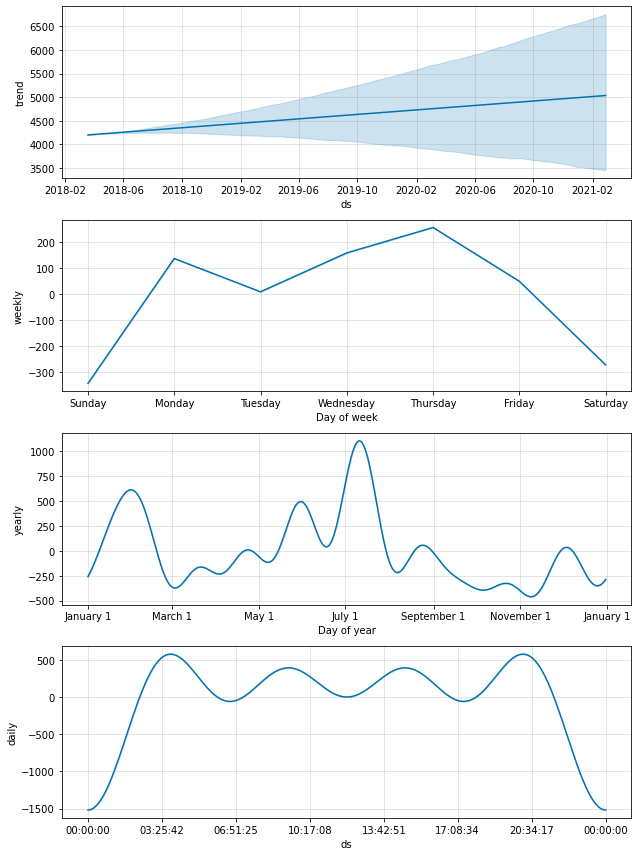

In [24]:
# Plotting the components of the forecast
model.plot_components(forecast)

## Multivariate Time series forecasting with Facebook Prophet

In [25]:
# we make use of our univariate dataset
new_df.head()

,ds,y
0,2010-09-01,2751.700
1,2010-09-02,570.810
2,2010-09-03,504.975
3,2010-09-04,502.275
4,2010-09-05,500.555


In [26]:
new_df["add1"] = df_daily['SysLoad']
new_df["add2"] = df_daily['Tmax']
new_df["add3"] = df_daily['GasPrice']      

In [27]:
new_df.head()

,ds,y,add1,add2,add3
0,2010-09-01,2751.700,41565.380,379.2,88.56
1,2010-09-02,570.810,38898.990,369.6,88.56
2,2010-09-03,504.975,41665.760,439.2,106.80
3,2010-09-04,502.275,35638.085,328.8,81.36
4,2010-09-05,500.555,35611.410,357.6,106.80


In [28]:
# Train and test sets similar to what was done before
x_test = new_df[2757:]
x_train = new_df[:2757]

In [29]:
x_test.shape, x_train.shape

((1077, 5), (2757, 5))

In [30]:
# Building Model - Prophet & Adding regressors
model_multi = Prophet(daily_seasonality=True)
model_multi.add_regressor('add1')
model_multi.add_regressor('add2')
model_multi.add_regressor('add3')
model_multi.fit(x_train)

In [31]:
# Predicting the test set 
forecast_multi = model_multi.predict(x_test)

In [32]:
forecast_multi.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,add1,add1_lower,add1_upper,add2,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-03-20,3282.354879,-230.893628,3940.974481,3282.354879,3282.354879,-856.348263,-856.348263,-856.348263,0.236909,...,-84.471995,-84.471995,-84.471995,-39.522698,-39.522698,-39.522698,0.0,0.0,0.0,1989.377259
1,2018-03-21,3283.049368,-403.830647,4173.892810,3283.049368,3283.049368,-1026.355400,-1026.355400,-1026.355400,0.234098,...,42.541964,42.541964,42.541964,-30.225522,-30.225522,-30.225522,0.0,0.0,0.0,1980.782986
2,2018-03-22,3283.743857,707.357280,5186.729413,3283.743857,3283.743857,-214.951453,-214.951453,-214.951453,0.220478,...,145.636345,145.636345,145.636345,-25.183861,-25.183861,-25.183861,0.0,0.0,0.0,2901.003845
3,2018-03-23,3284.438346,402.914924,4847.100087,3284.438346,3284.438346,-274.887659,-274.887659,-274.887659,0.212479,...,-44.301841,-44.301841,-44.301841,-24.256467,-24.256467,-24.256467,0.0,0.0,0.0,2585.273253
4,2018-03-24,3285.132835,-944.973485,3585.716216,3285.132835,3285.132835,-1076.398887,-1076.398887,-1076.398887,0.210534,...,-117.564139,-117.564139,-117.564139,-27.192710,-27.192710,-27.192710,0.0,0.0,0.0,1438.551310


## Question 17

In [33]:
# Computing the MAPE
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

actual = x_test['y']
pred = forecast_multi['yhat']

mape(actual, pred)

233.39745283793448

## Question 18

In [34]:
# Computing the RMSE by comparing the real values and the forecasted values
mse_prophet = mean_squared_error(x_test.y,forecast_multi.yhat)
print ("RMSE FOR PROPHET {:.2f}".format(np.sqrt(mse_prophet)))

RMSE FOR PROPHET 2709.25


## Question 19

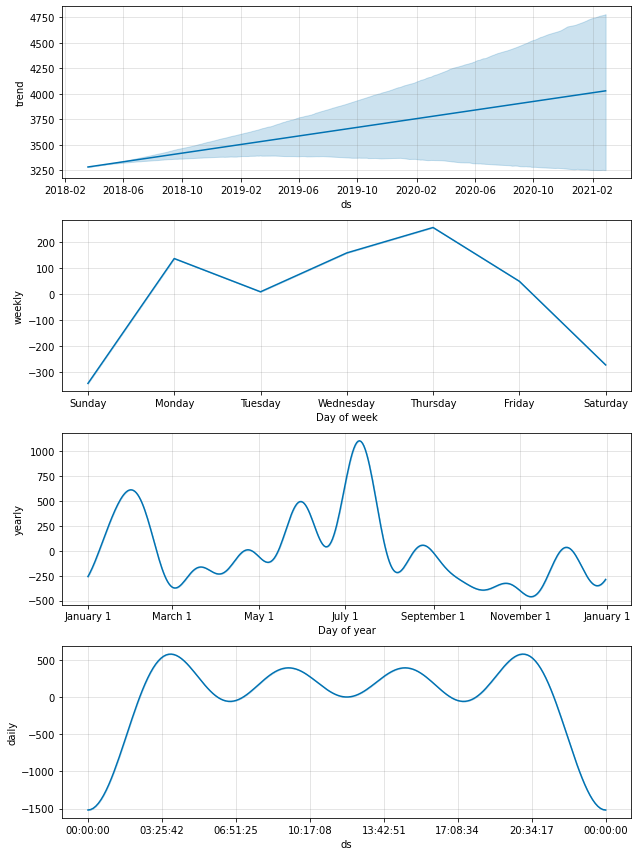

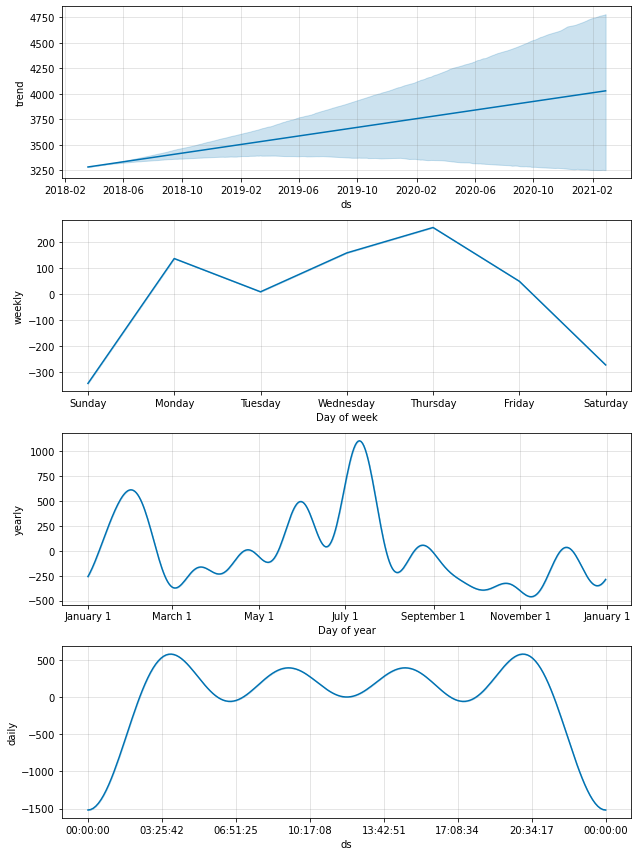

In [35]:
# Plotting the components of the multivariate forecast
model.plot_components(forecast_multi)

## Question 20

In [36]:
df_tmax = new_df.drop(columns='add2')

In [37]:
df_tmax.head()

,ds,y,add1,add3
0,2010-09-01,2751.700,41565.380,88.56
1,2010-09-02,570.810,38898.990,88.56
2,2010-09-03,504.975,41665.760,106.80
3,2010-09-04,502.275,35638.085,81.36
4,2010-09-05,500.555,35611.410,106.80


In [38]:
# Train and test sets similar to what was done before
x_test = df_tmax[2757:]
x_train = df_tmax[:2757]

In [39]:
x_test.shape, x_train.shape

((1077, 4), (2757, 4))

In [40]:
# Building Model - Prophet & Adding regressors
model_multi = Prophet(daily_seasonality=True)
model_multi.add_regressor('add1')
model_multi.add_regressor('add3')
model_multi.fit(x_train)

In [41]:
# Predicting the test set 
forecast_tmax = model_multi.predict(x_test)

In [42]:
forecast_tmax.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,add1,add1_lower,add1_upper,add3,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-03-20,3261.855624,-155.356413,4238.350100,3261.855624,3261.855624,-855.330389,-855.330389,-855.330389,1101.266312,...,-84.189849,-84.189849,-84.189849,-38.661722,-38.661722,-38.661722,0.0,0.0,0.0,1990.771007
1,2018-03-21,3262.550415,-350.846538,4150.876554,3262.550415,3262.550415,-1025.135452,-1025.135452,-1025.135452,1125.736663,...,42.705804,42.705804,42.705804,-29.357148,-29.357148,-29.357148,0.0,0.0,0.0,1982.331312
2,2018-03-22,3263.245205,873.420622,5167.199988,3263.245205,3263.245205,-214.695957,-214.695957,-214.695957,1125.736663,...,145.366763,145.366763,145.366763,-24.305132,-24.305132,-24.305132,0.0,0.0,0.0,2901.178572
3,2018-03-23,3263.939995,294.084545,4894.187884,3263.939995,3263.939995,-274.560922,-274.560922,-274.560922,1058.099908,...,-44.016978,-44.016978,-44.016978,-23.364983,-23.364983,-23.364983,0.0,0.0,0.0,2585.928050
4,2018-03-24,3264.634785,-1007.943168,3559.317524,3264.634785,3264.634785,-1075.119456,-1075.119456,-1075.119456,787.728934,...,-117.919240,-117.919240,-117.919240,-26.286721,-26.286721,-26.286721,0.0,0.0,0.0,1438.869331


In [43]:
# Computing the MAPE
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

actual = x_test['y']
pred = forecast_tmax['yhat']

mape(actual, pred)

233.3766495305714